In [47]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from skimage.color import label2rgb
from tifffile import imread
from os import listdir, makedirs

from yoeo.main import get_dv2_model, get_upsampler_and_expr, get_hr_feats, get_lr_feats, convert_image, closest_crop
from yoeo.utils import to_numpy

from interactive_seg_backend import featurise_
from interactive_seg_backend.configs import FeatureConfig, TrainingConfig, CRFParams
from interactive_seg_backend.classifiers.base import Classifier
from interactive_seg_backend.file_handling import load_labels, load_image, save_segmentation
from interactive_seg_backend.core import train, get_training_data, shuffle_sample_training_data, get_model
from interactive_seg_backend.core import apply_
from interactive_seg_backend.main import apply
from interactive_seg_backend.utils import class_avg_miou


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.colors import to_rgba


from typing import Literal

SEED = 10672
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = "cuda:1"

In [2]:
cmap = [
            "#fafafa",
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
        ]
color_list = [[255, 255, 255], [31, 119, 180], [255, 127, 14], [44, 160, 44], [255, 0, 0]]
COLORS = np.array(color_list) / 255.0

In [3]:
dv2 = get_dv2_model(True, device=DEVICE)

model_path = "../trained_models/e5000_full_fit_reg.pth"
cfg_path = "../yoeo/models/configs/combined_no_shift.json"

upsampler, expr = get_upsampler_and_expr(model_path, cfg_path, device=DEVICE)

Using cache found in /home/ronan/.cache/torch/hub/ywyue_FiT3D_main


In [4]:
PATH = "fig_data/is_benchmark"
AllowedDatasets = Literal["Cu_ore_RLM", "Ni_superalloy_SEM", "T_cell_TEM"]
dataset: tuple[AllowedDatasets, ...] = ("Cu_ore_RLM", "Ni_superalloy_SEM", "T_cell_TEM")

TRAIN_IMG_FNAMES: dict[AllowedDatasets, list[str]] = {"Cu_ore_RLM": ["001", "028", "049", "068"], 
                                                      "Ni_superalloy_SEM": ["000", "001", "005", "007"], 
                                                      "T_cell_TEM": ["000", "027", "021", "105"]
                                                      }

In [5]:
def get_deep_feats(img: Image.Image, K: int =32, existing_pca: object | None = None) -> np.ndarray:
    hr_feats = get_hr_feats(img, dv2, upsampler, DEVICE, n_ch_in=expr.n_ch_in, existing_pca=existing_pca)
    hr_feats_np = to_numpy(hr_feats)
    hr_feats_np = hr_feats_np.transpose((1, 2, 0))[:, :, :K]
    return hr_feats_np

def train_model_over_images(dataset: AllowedDatasets, train_cfg: TrainingConfig) -> tuple[Classifier, object]:
    features, labels = [], []
    train_fnames = TRAIN_IMG_FNAMES[dataset]

    pca = None
    if train_cfg.add_dino_features:
        imgs = []
        for fname in sorted(listdir(f"{PATH}/{dataset}/images")):
            img_path = f"{PATH}/{dataset}/images/{fname}"
            arr = load_image(img_path)
            img = Image.fromarray(arr).convert('RGB')
            tr = closest_crop(img.height, img.width)
            tensor = convert_image(img, tr, device_str=DEVICE)
            imgs.append(tensor)

        _, pca = get_lr_feats(dv2, imgs, n_imgs=150, fit3d=True)


    for fname in train_fnames:
        img_path = f"{PATH}/{dataset}/images/{fname}.tif"
        labels_path = f"{PATH}/{dataset}/labels/{fname}.tif"

        img_arr = load_image(img_path)
        label_arr = load_labels(labels_path)

        feats = featurise_(img_arr, train_cfg.feature_config)
        if train_cfg.add_dino_features:
            img = Image.fromarray(img_arr).convert('RGB')
            deep_feats = get_deep_feats(img, 32, pca)
            feats = np.concatenate((feats, deep_feats), axis=-1)

        features.append(feats)
        labels.append(label_arr)

    print('Finished featurising')
    fit, target = get_training_data(features, labels)
    fit, target = shuffle_sample_training_data(
        fit, target, train_cfg.shuffle_data, train_cfg.n_samples
    )
    model = get_model(
        train_cfg.classifier, train_cfg.classifier_params, train_cfg.use_gpu
    )
    model = train(model, fit, target, None)
    return model, pca

In [6]:
def apply_model_over_images(dataset: AllowedDatasets, train_cfg: TrainingConfig, model: Classifier, verbose: bool=False, early_cutoff_n: int = -1, existing_pca: object | None = None) -> dict[str, np.ndarray]:
    preds: dict[str, np.ndarray] = {}
    img_fnames = sorted(listdir(f"{PATH}/{dataset}/images"))
    N_imgs = len(img_fnames)

    selected_imgs = img_fnames if early_cutoff_n <= 0 else img_fnames[:early_cutoff_n]

    for i, fname in enumerate(selected_imgs):
        if verbose and i % 10 == 0:
            print(f"[{i:02d}/{N_imgs}] - {fname}")
        img_path = f"{PATH}/{dataset}/images/{fname}"
        img_arr = load_image(img_path)

        feats = featurise_(img_arr, train_cfg.feature_config)
        if train_cfg.add_dino_features:
            img = Image.fromarray(img_arr).convert('RGB')
            deep_feats = get_deep_feats(img, 32, existing_pca=existing_pca)
            feats = np.concatenate((feats, deep_feats), axis=-1)

        pred, _ = apply(model, feats, train_cfg, image=img_arr) #apply_(model, feats)
        preds[fname] = pred
    return preds

In [7]:
def eval_preds(dataset: AllowedDatasets, preds: dict[str, np.ndarray]) -> float:
    mious: list[float] = []
    seg_fnames = sorted(listdir(f"{PATH}/{dataset}/segmentations"))
    for i, fname in enumerate(seg_fnames):
        seg_path = f"{PATH}/{dataset}/segmentations/{fname}"
        pred = preds[fname]
        ground_truth = load_labels(seg_path)
        miou = class_avg_miou(pred, ground_truth)
        mious.append(miou)
    return np.mean(mious)

In [8]:
chosen_dataset: AllowedDatasets = "Ni_superalloy_SEM"

In [9]:
feat_cfg = FeatureConfig()

classical_train_cfg = TrainingConfig(feat_cfg, n_samples=-1, add_dino_features=False, classifier='xgb', classifier_params = {"class_weight": "balanced"},)
classical_model, _ = train_model_over_images(chosen_dataset, classical_train_cfg)

deep_train_cfg = TrainingConfig(feat_cfg, n_samples=-1, add_dino_features=True, classifier='xgb', classifier_params = {"class_weight": "balanced"},)
deep_model, pca = train_model_over_images(chosen_dataset, deep_train_cfg)

Finished featurising
Finished featurising


In [10]:
classical_preds = apply_model_over_images(chosen_dataset, classical_train_cfg, classical_model, verbose=True)
deep_preds = apply_model_over_images(chosen_dataset, deep_train_cfg, deep_model, verbose=True, existing_pca=pca)

[00/23] - 000.tif
[10/23] - 010.tif
[20/23] - 020.tif
[00/23] - 000.tif
[10/23] - 010.tif
[20/23] - 020.tif


In [49]:
SAVE = True
if SAVE:
    classical_folder = f"{PATH}/{chosen_dataset}/preds/classical"
    deep_folder = f"{PATH}/{chosen_dataset}/preds/deep"
    makedirs(classical_folder, exist_ok=True)
    makedirs(deep_folder, exist_ok=True)

    for folder, pred_dict in zip((classical_folder, deep_folder), (classical_preds, deep_preds)):
        for fname, seg in pred_dict.items():
            save_segmentation(seg, f"{folder}/{fname}")

In [11]:
miou_classical = eval_preds(chosen_dataset, classical_preds)
miou_deep = eval_preds(chosen_dataset, deep_preds)

print(f"mIoU_classical: {miou_classical} vs mIoU_deep: {miou_deep}")

mIoU_classical: 0.5398494931057901 vs mIoU_deep: 0.7017500092335176


In [12]:
TITLE_FS = 25
LABEL_FS = 23
TICK_FS = 21
PAD = 60

def hide_axis_ticks(ax, frameoff: bool=True):
    ax.tick_params(which="both", bottom=False, top=False, left=False, right=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    if frameoff:
        ax.set_frame_on(False)


def add_stacked_rects(fig, subplot):
    outer_pos = subplot.get_position(fig) 

    x0, y0 = outer_pos.x0, outer_pos.y0
    width, height = outer_pos.width, outer_pos.height

    # Base color
    base_color = np.array(to_rgba('#bbbbbb'))

    for n in range(3):  # 3 stacked layers
        T = 0.005
        offset = n * T  # tweak this for separation between layers
        darken = 0.05 * n   # tweak this for how much darker each layer is
        color = np.clip(base_color - darken, 0, 1)  # slightly darker with each layer

        rect = Rectangle(
            (x0 + T + offset, y0 + T + offset),  # move up and right a bit
            width , height,
            transform=fig.transFigure,
            color=color,
            zorder=-n - 1,  # stack order: bottom first
            alpha=1,
            linewidth=1,
            edgecolor='black'
        )
        fig.patches.append(rect)

plt.rcParams["font.family"] = "serif"

In [25]:
%%capture
img_paths = sorted(listdir(f"{PATH}/{chosen_dataset}/images"))[::5]

n_samples = len(img_paths)
fig, axs = plt.subplots(nrows=4, ncols=n_samples)

fig.set_size_inches((18, 16))


for i, img_fname in enumerate(img_paths):
    img = imread(f"{PATH}/{chosen_dataset}/images/{img_fname}")
    gt_seg = imread(f"{PATH}/{chosen_dataset}/segmentations/{img_fname}")

    classical_pred = classical_preds[img_fname]
    deep_pred = deep_preds[img_fname]

    ax0, ax1, ax2, ax3 = axs[: ,i]
    ax0.imshow(img, cmap='binary_r')
    ax1.imshow(label2rgb(gt_seg, colors=COLORS[1:]))
    ax2.imshow(label2rgb(classical_pred + 1, colors=COLORS[1:]))
    ax3.imshow(label2rgb(deep_pred + 1, colors=COLORS[1:]))

    if i == 0:
        ax0.set_ylabel('Image', fontsize=TITLE_FS)
        ax1.set_ylabel('Ground truth', fontsize=TITLE_FS)
        ax2.set_ylabel('Classical', fontsize=TITLE_FS)
        ax3.set_ylabel('+ HR ViT features', fontsize=TITLE_FS)
    
    ax0.set_title(img_fname, fontsize=TITLE_FS)

    for ax in (ax0, ax1, ax2, ax3):
        hide_axis_ticks(ax)

plt.tight_layout()

In [38]:
test_img_fnames = [f for f in sorted(listdir(f"{PATH}/{chosen_dataset}/images")) if f not in TRAIN_IMG_FNAMES[chosen_dataset]][::-1]

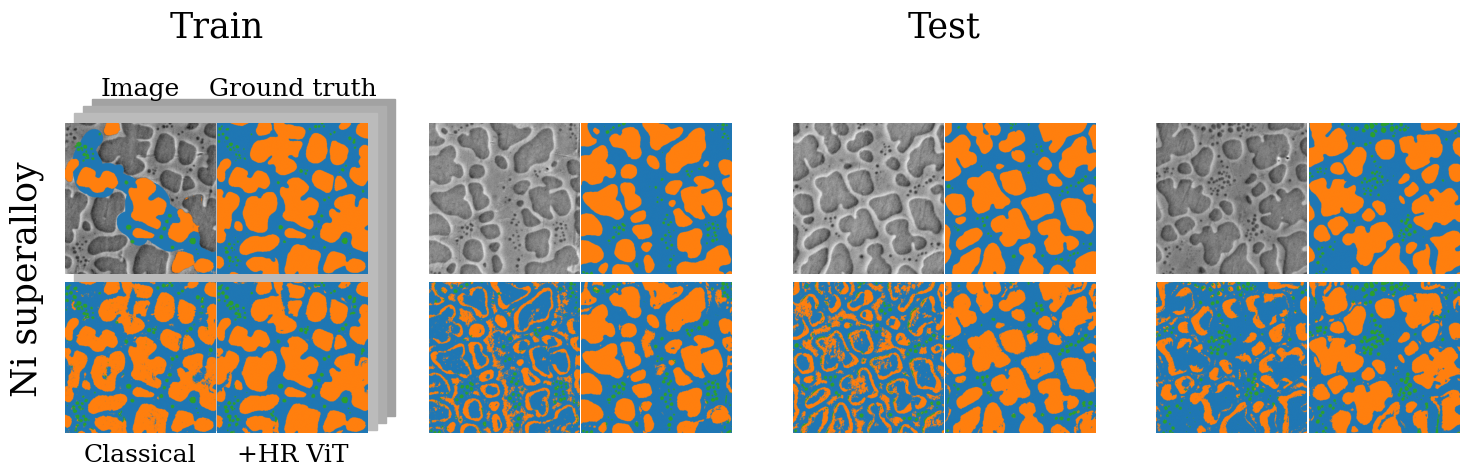

In [ ]:
# %%capture
datasets: list[AllowedDatasets] = ["Ni_superalloy_SEM"] 
titles = ["Ni superalloy", "T cell", "Cu ore"]



def do_fourplot(dataset: AllowedDatasets, filename: str, parent_grid, classical_preds: dict[str, np.ndarray], deep_preds: dict[str, np.ndarray],  is_train: bool, is_top_left_corner: bool = False):
    inner_grid = gridspec.GridSpecFromSubplotSpec(2, 2,
                subplot_spec=parent_grid, wspace=0.01, hspace=0.01)

    for k in range(4):  # Each image (original + 3 derivatives)
        ax = plt.Subplot(fig, inner_grid[k // 2, k % 2])
        # ax.imshow(datasets[i][j][k], cmap='gray')
        hide_axis_ticks(ax)
        fig.add_subplot(ax)

        if is_very_top_corner and k < 2:
            ax.set_title(subfig_titles[k], fontsize=LABEL_FS-5, pad=20)
        elif is_very_top_corner and k >= 2:
            ax.set_xlabel(subfig_titles[k], fontsize=LABEL_FS-5, labelpad=0)
        
        if k == 0:
            img = imread(f"{PATH}/{dataset}/images/{filename}")

            if is_train:
                labels = imread(f"{PATH}/{dataset}/labels/{filename}")
                labels_unsqueezed = np.expand_dims(labels[0], -1)

                overlay = label2rgb(labels[0], colors=COLORS[1:], kind='overlay', bg_label=0, image_alpha=1, alpha=1)
                out = np.where(labels_unsqueezed, overlay * 255, np.expand_dims(img, -1)).astype(np.uint8)
                img_with_labels = Image.fromarray(out)

                ax.imshow(img_with_labels, cmap='binary_r')
            else:
                ax.imshow(img, cmap='binary_r')

        elif k == 1:
            gt_seg = imread(f"{PATH}/{dataset}/segmentations/{filename}")
            ax.imshow(label2rgb(gt_seg, colors=COLORS[1:]))
        elif k == 2:
            classical_seg = classical_preds[f"{filename}"]
            ax.imshow(label2rgb(classical_seg + 1, colors=COLORS[1:]))
        elif k == 3:
            deep_seg = deep_preds[f"{filename}"]
            ax.imshow(label2rgb(deep_seg + 1, colors=COLORS[1:]))


fig = plt.figure(figsize=(18, 14))
outer_grid = gridspec.GridSpec(3, 4, wspace=0.2, hspace=0.2)  # 3 rows (datasets), 4 columns (examples per dataset)

for i in range(1):  # Dataset rows
    ax_train_label = plt.Subplot(fig, outer_grid[i, 0])
    ax_train_label.set_ylabel(titles[i], fontsize=TITLE_FS, labelpad=PAD-40, rotation=90, va='center')
    ax_test_label = plt.Subplot(fig, outer_grid[i, 2])
    if i == 0:
        ax_train_label.set_title('Train', fontsize=TITLE_FS, pad=PAD)
        ax_test_label.set_title('Test', fontsize=TITLE_FS, pad=PAD)

    add_stacked_rects(fig, outer_grid[i, 0])
    hide_axis_ticks(ax_train_label)
    fig.add_subplot(ax_train_label)
    hide_axis_ticks(ax_test_label)
    fig.add_subplot(ax_test_label)

    outer_pos = outer_grid[i, 0].get_position(fig)
    # Coordinates of the 2x2 block to be used as background
    x0, y0 = outer_pos.x0, outer_pos.y0
    width, height = outer_pos.width, outer_pos.height


    subfig_titles = ["Image", "Ground truth", "Classical", '+HR ViT']

    chosen_dataset = datasets[i]
    img_fnames = sorted(listdir(f"{PATH}/{chosen_dataset}/images"))
    seg_fnames = sorted(listdir(f"{PATH}/{chosen_dataset}/segmentations"))

    train_example = TRAIN_IMG_FNAMES[chosen_dataset][2] + '.tif'

    for j in range(4):  # 4 examples per dataset

        is_very_top_corner = i == 0 and j == 0
        is_train_example = j == 0

        example_fname = train_example if j == 0 else test_img_fnames[j]

        do_fourplot(chosen_dataset, example_fname, outer_grid[i, j], classical_preds, deep_preds, is_train_example, is_very_top_corner)


plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make space for suptitle
plt.savefig('fig_out/is_examples.png' ,bbox_inches='tight')